### Preparation

In [1]:
import tqdm
import os
import cv2
import imghdr

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy

In [2]:
data_dir = 'D:\DATASETS\For-Thesis\Labels'

In [3]:
def sample_count(data_dir):
    for dir in os.listdir(data_dir):
        print("{}: {}".format(dir, len(os.listdir(os.path.join(data_dir,dir)))))

In [4]:
sample_count(data_dir)

Asphalt Road: 50
Building: 56
Concrete Road: 122
Plant: 68
Vehicle: 63


In [106]:
labels = ['Asphalt Road', 'Building', 'Concrete Road', 'Plant', 'Vehicle']
X_train = []
y_train = []
y_one_hot = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        y_one_hot.append(labels.index(i))
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train_scaled = X_train.astype(np.float32) / 255.0
y_one_hot = tf.keras.utils.to_categorical(y_one_hot)

In [110]:
y_train[1], y_one_hot[50]

('Asphalt Road', array([0., 1., 0., 0., 0.], dtype=float32))

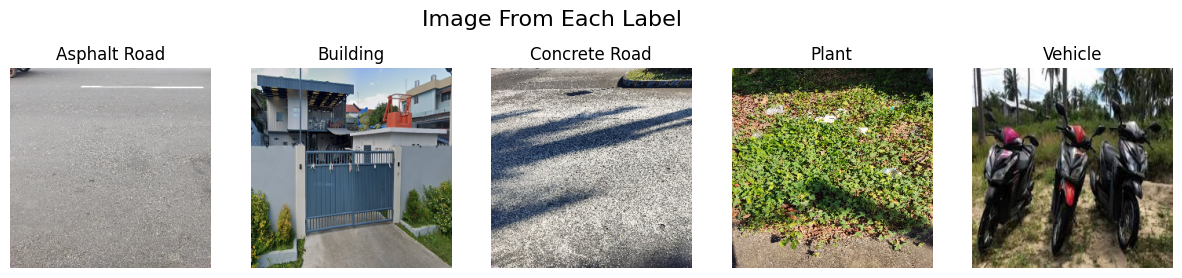

In [111]:
fig, ax = plt.subplots(1,5,figsize=(15,15))
fig.text(s='Image From Each Label', y=0.59, x=0.4, fontsize=16)
k = 0
idx = []
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            ax[k].imshow(X_train[j][...,::-1]) # Matplotlib expects RGB. cv2 opens it as BGR. BGR to RGB
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k += 1
            idx.append(j)
            break
        j += 1

### Prepare Dataset

In [112]:
idx

[0, 50, 106, 228, 296]

In [113]:
a_road = X_train_scaled[0:50]
a_road_label = y_one_hot[0:50]

b = X_train_scaled[50:106]
b_label = y_one_hot[50:106]

c_road = X_train_scaled[106:228]
c_road_label = y_one_hot[106:228]

p = X_train_scaled[228:296]
p_label = y_one_hot[228:296]

v = X_train_scaled[296:]
v_label = y_one_hot[296:]

In [114]:
a_dataset = tf.data.Dataset.from_tensor_slices((a_road, a_road_label))
b_dataset = tf.data.Dataset.from_tensor_slices((b, b_label))
c_dataset = tf.data.Dataset.from_tensor_slices((c_road, c_road_label))
p_dataset = tf.data.Dataset.from_tensor_slices((p, p_label))
v_dataset = tf.data.Dataset.from_tensor_slices((v, v_label))

In [115]:
len(a_dataset)

50

In [116]:
a_road[0]

array([[[0.58431375, 0.6313726 , 0.5764706 ],
        [0.45882353, 0.57254905, 0.47058824],
        [0.63529414, 0.6627451 , 0.6784314 ],
        ...,
        [0.76862746, 0.7764706 , 0.78039217],
        [0.76862746, 0.7764706 , 0.78039217],
        [0.7607843 , 0.7647059 , 0.78039217]],

       [[0.35686275, 0.5019608 , 0.43529412],
        [0.13333334, 0.1254902 , 0.1254902 ],
        [0.2901961 , 0.28235295, 0.32941177],
        ...,
        [0.75686276, 0.7647059 , 0.76862746],
        [0.7607843 , 0.76862746, 0.77254903],
        [0.7607843 , 0.76862746, 0.7764706 ]],

       [[0.32941177, 0.3529412 , 0.7137255 ],
        [0.2509804 , 0.28235295, 0.61960787],
        [0.25490198, 0.29411766, 0.57254905],
        ...,
        [0.7764706 , 0.78431374, 0.7882353 ],
        [0.7607843 , 0.76862746, 0.77254903],
        [0.7607843 , 0.76862746, 0.77254903]],

       ...,

       [[0.68235296, 0.6666667 , 0.7137255 ],
        [0.40392157, 0.3764706 , 0.42745098],
        [0.5803922 , 0

In [117]:
def base_shuffle(df):
    return df.shuffle(buffer_size=df.cardinality(), seed=1)

In [118]:
a_dataset_b = base_shuffle(a_dataset)
b_dataset_b = base_shuffle(b_dataset)
c_dataset_b = base_shuffle(c_dataset)
p_dataset_b = base_shuffle(p_dataset)
v_dataset_b = base_shuffle(v_dataset)

In [119]:
len(a_dataset_b)

50

In [120]:
def train_test(ds, mode='train'):
    size = len(ds)
    train_count = (size * 4) // 5   # 80% of samples will be training data
    test_count = size - train_count
    train_set = ds.take(train_count)
    test_set = ds.skip(train_count).take(test_count)
    if mode == 'train':
        return train_set
    else:
        return test_set

In [121]:
aa_train = train_test(a_dataset_b)
aa_test = train_test(a_dataset_b, mode='test')

bb_train = train_test(b_dataset_b)
bb_test = train_test(b_dataset_b, mode='test')

cc_train = train_test(c_dataset_b)
cc_test = train_test(c_dataset_b, mode='test')

pp_train = train_test(p_dataset_b)
pp_test = train_test(p_dataset_b, mode='test')

vv_train = train_test(v_dataset_b)
vv_test = train_test(v_dataset_b, mode='test')

In [122]:
aa.batch(8)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [123]:
# Concatenate training sets and testing sets
combined_train_dataset = aa_train.concatenate(bb_train)
combined_train_dataset = combined_train_dataset.concatenate(cc_train)
combined_train_dataset = combined_train_dataset.concatenate(pp_train)
combined_train_dataset = combined_train_dataset.concatenate(vv_train)

In [124]:
len(combined_train_dataset)

285

In [125]:
combined_train_dataset = combined_train_dataset.shuffle(buffer_size=combined_train_dataset.cardinality()).batch(8)
combined_train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [126]:
combined_test_dataset = aa_test.concatenate(bb_test)
combined_test_dataset = combined_test_dataset.concatenate(cc_test)
combined_test_dataset = combined_test_dataset.concatenate(pp_test)
combined_test_dataset = combined_test_dataset.concatenate(vv_test)

In [127]:
combined_test_dataset = combined_test_dataset.shuffle(buffer_size=combined_test_dataset.cardinality()).batch(8)
combined_test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

### Make Model

In [ ]:
model = Sequential()
model.add(RandomFlip(mode='horizontal_and_vertical', seed=1, input_shape=(256,256,3)))
model.add(RandomRotation(factor=0.2, seed=1))

model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=64,activation="relu"))

model.add(Dense(units=4, activation="softmax"))
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=[tf.metrics.CategoricalAccuracy()])

In [128]:
!pip freeze > requirements.txt